# Activations and Initializations


In this course, we will revisit the Fully Connected model presented in Course 5 on NLP. We will study the behavior of activations throughout the network during its initialization. This course is inspired by Andrej Karpathy's course, titled [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=3892s&ab_channel=AndrejKarpathy).


Neural networks have several advantages:
- They are very flexible and can solve many problems.
- They are relatively simple to implement.

However, they can be complex to optimize, especially when dealing with deep networks.


## Code Review


We are revisiting the code from [Notebook 3 of Course 5 on NLP](../05_NLP/03_RéseauFullyConnected.ipynb).


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../05_NLP/prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

For educational purposes, we will not use PyTorch's dataset and dataloader. We will evaluate the loss at the beginning of training after the first batch. Overall, it works the same way, except that we take a random batch at each iteration instead of going through the entire dataset at each epoch.


In [3]:
block_size = 3 # Contexte

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([180834, 3]) torch.Size([180834])
torch.Size([22852, 3]) torch.Size([22852])
torch.Size([22639, 3]) torch.Size([22639])


In [4]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [5]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # Permet de construire un mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # Forward
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 

  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  # Retropropagation
  for p in parameters:
    p.grad = None
  
  loss.backward()
  # Mise à jour des paramètres
  lr = 0.1 if i < 100000 else 0.01 # On descend le learning rate d'un facteur 10 après 100000 itérations
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 21.9772
  10000/ 200000: 2.9991
  20000/ 200000: 2.5258
  30000/ 200000: 1.9657
  40000/ 200000: 2.4326
  50000/ 200000: 1.7670
  60000/ 200000: 2.1324
  70000/ 200000: 2.4160
  80000/ 200000: 2.2237
  90000/ 200000: 2.3905
 100000/ 200000: 1.9304
 110000/ 200000: 2.1710
 120000/ 200000: 2.3444
 130000/ 200000: 2.0970
 140000/ 200000: 1.8623
 150000/ 200000: 1.9792
 160000/ 200000: 2.4602
 170000/ 200000: 2.0968
 180000/ 200000: 2.0466
 190000/ 200000: 2.3746


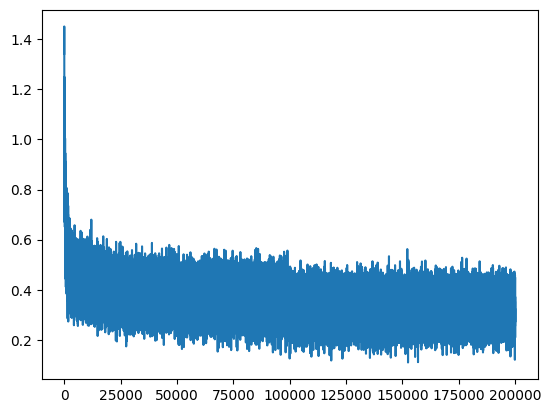

In [6]:
plt.plot(lossi)

There is a lot of "noise" because we calculate the loss each time on small batches relative to the entire training dataset.


## Abnormally High Loss at Initialization


Training proceeds correctly. However, we notice something strange: the loss at the beginning of training is abnormally high. We would expect to get a value corresponding to a case where each letter has a uniform probability of occurrence (i.e., $\frac{1}{46}$).

In this case, the negative log likelihood would be:
$-ln(\frac{1}{46})=3.83$

Therefore, it would be logical to obtain a value of this magnitude during the first loss calculation.


### Small Example Illustrating the Problem


To understand what is happening, let's use a small example and observe the loss values depending on the initialization. Imagine that all the weights in *logits* are initialized to 0. In this case, we would obtain uniform probabilities.


In [7]:
logits=torch.tensor([0.0,0.0,0.0,0.0])
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

However, it is not recommended to initialize the weights of a neural network to 0. We used a random initialization based on a standard normal Gaussian distribution.


In [8]:
logits=torch.randn(4)
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.3143, 0.0607, 0.3071, 0.3178]), tensor(2.8012))

The problem becomes quickly apparent: the randomness of the Gaussian distribution tips the balance one way or the other (you can run the previous code several times to confirm this).

So, what can we do? Simply multiply our *logit* vector by a small value to decrease the initial weight values and make the *softmax* more uniform.


In [9]:
logits=torch.randn(4)*0.01
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2489, 0.2523, 0.2495, 0.2493]), tensor(1.3772))

We obtain, more or less, the same loss as for uniform probabilities.

**Note**: However, we can initialize the bias value to zero, as it makes no sense to have a positive or negative bias at initialization.


### Training with Initialization Adjustment


Let's revisit the previous code, but with the new initialization values.


In [10]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))*0.01 # On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46))*0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [11]:
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 
  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.8304
  10000/ 200000: 2.4283
  20000/ 200000: 2.0651
  30000/ 200000: 2.1124
  40000/ 200000: 2.3158
  50000/ 200000: 2.2752
  60000/ 200000: 2.1887
  70000/ 200000: 2.1783
  80000/ 200000: 1.8120
  90000/ 200000: 2.3178
 100000/ 200000: 2.0973
 110000/ 200000: 1.8992
 120000/ 200000: 1.6917
 130000/ 200000: 2.2747
 140000/ 200000: 1.8054
 150000/ 200000: 2.3569
 160000/ 200000: 2.4231
 170000/ 200000: 2.0711
 180000/ 200000: 2.1379
 190000/ 200000: 1.8419


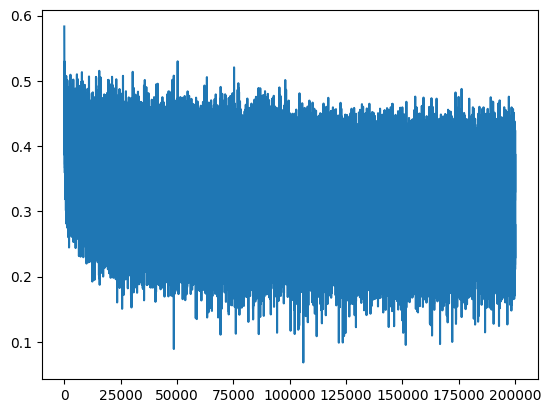

In [12]:
plt.plot(lossi)

We now have a loss curve that does not start at an aberrant value, which speeds up optimization.


## Another Problem


One might think that a high loss is not necessarily a problem. However, poor weight initialization can cause other issues.

Consider the first iteration of training with values initialized without the 0.01 factor.


In [13]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) 
b1 = torch.randn(hidden_dim) 
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [14]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

We look at the histogram of values after the *tanh* activation function.


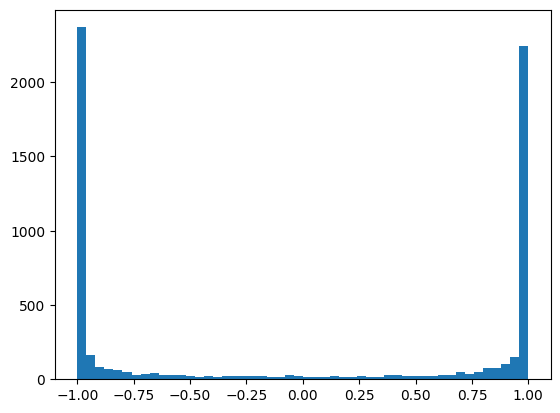

In [15]:
plt.hist(h.view(-1).tolist(),50);

We observe that most of the values are around 1 or -1.

What is the problem with this?
When calculating the gradient, using the chain rule, we multiply the gradients of the different calculation steps. The derivative of the *tanh* function is:
$tanh'(t)= 1 - t^2$
If the values of $t$ are at 1 or -1, then the gradient will be extremely small (never zero, as it's an asymptote). This means that the gradient does not propagate, and therefore optimization cannot function optimally at the beginning of training.

We can visualize the values of each neuron.


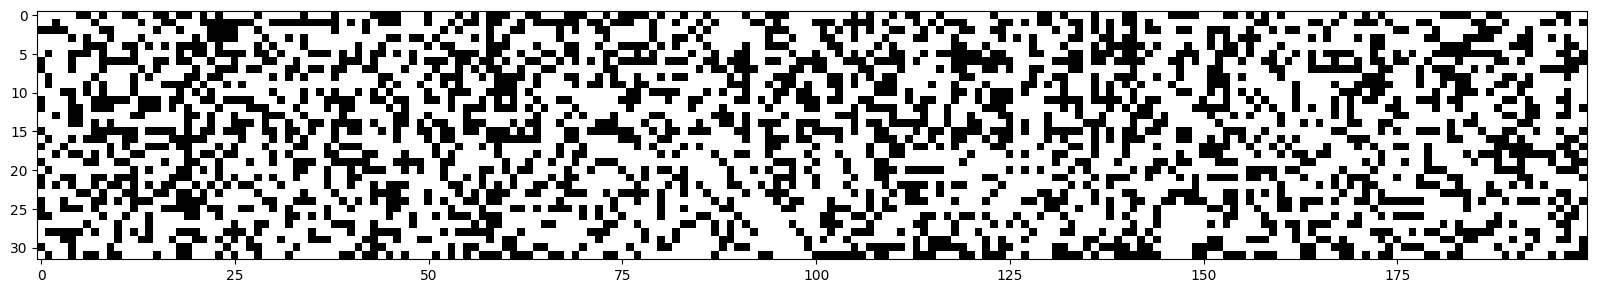

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

Each white dot corresponds to a neuron whose gradient is approximately equal to 0.

**Dead Neuron**: If one of these columns were entirely white, it would mean that the neuron does not activate on any element (of the *batch*). This means it is a useless neuron, which will have no impact on the result and cannot be optimized (on the values present in this *batch*).

**Notes**:
- This type of behavior is not exclusive to *tanh*: *sigmoid* and *ReLU* can have the same problem.
- The problem did not prevent us from training our network correctly, as it is a small model. On deeper networks, this is a big problem, and it is advisable to check the activations of your network at different stages.
- Dead neurons can appear at initialization, but also during training if the *learning rate* is too high, for example.


### How to Solve This Problem?


Fortunately, this problem can be solved in exactly the same way as the problem of the too high *loss*. To ensure this, let's look at the activation values and inactive neurons at initialization with our new values.


In [17]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) *0.01# On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46)) *0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [18]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

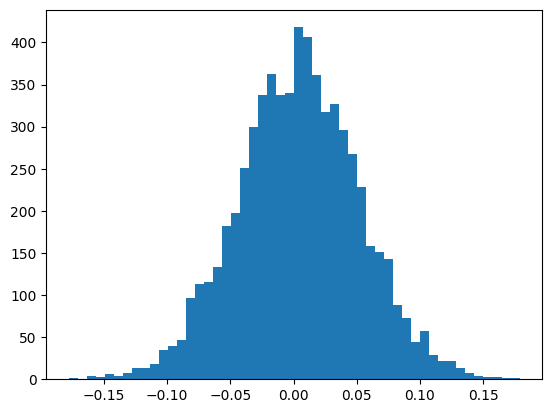

In [19]:
plt.hist(h.view(-1).tolist(),50);

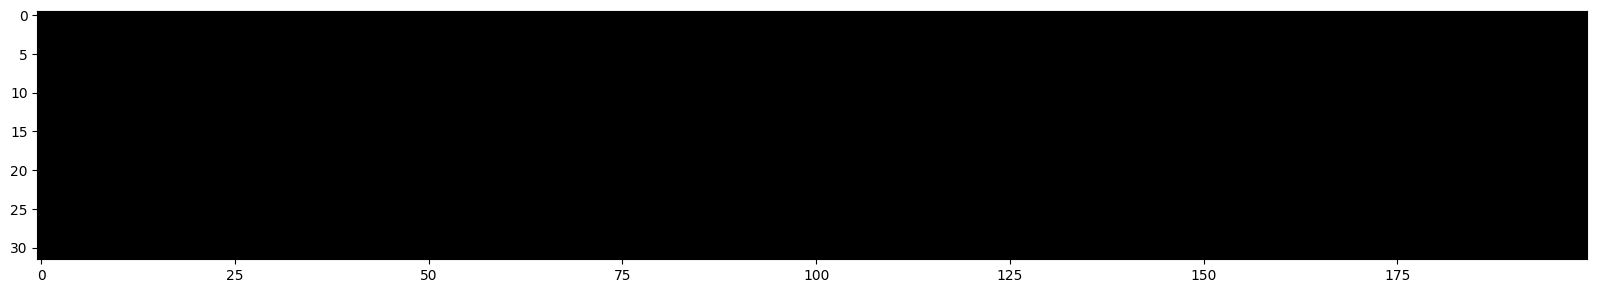

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

Everything is going well!


### Optimal Values at Initialization


This problem being very important, many researches have been directed towards this subject. A notable publication is [Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852), which introduces the *Kaiming initialization*. The paper proposes initialization values for each activation function that guarantee a standard normal distribution across the entire network.

This method is implemented in [PyTorch](https://pytorch.org/docs/stable/nn.init.html), and the layers we will create in PyTorch are directly initialized in this manner.


### Why is this course in the bonus section when it seems very important?


This is indeed a major problem. However, when using PyTorch, everything is already initialized correctly, and it is generally not necessary to modify these values.

Furthermore, many methods have been proposed to mitigate this problem, mainly:
- *Batch normalization*, which we will see in the next notebook, which consists of normalizing the values before activation throughout the network.
- Residual connections, which allow the gradient to be transmitted throughout the network without being too impacted by the activation functions.

Despite the importance of these considerations, in practice, it is not always necessary to be aware of them to train a neural network.
